In [20]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import time
import numpy as np
from IPython import display

In [21]:
# Hyperparameters
BUFFER_SIZE = 60000
BATCH_SIZE = 20
DATASET_PATH = "dataset\Boot"

In [22]:
def image_generator(image_folder):
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
    
    def preprocess_image(image_path):
        # Load image
        img = load_img(image_path, target_size=(32, 32, 3))
        img_array = img_to_array(img)

        # Normalize the images to [-1, 1]
        img_array = (img_array - 127.5) / 127.5
        return img_array
    
    for image_file in image_files:
        yield preprocess_image(image_file)

train_dataset = tf.data.Dataset.from_generator(
    image_generator,
    output_signature=tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
    args=[DATASET_PATH]
)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


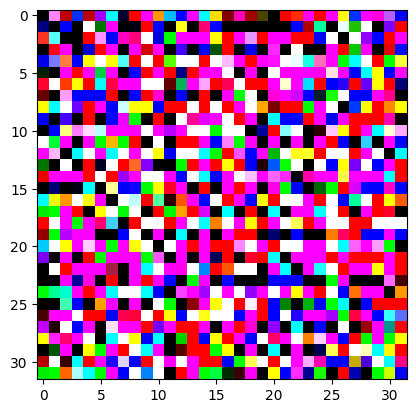

In [23]:
# Create the base generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)), # Random noise with size 100
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

    assert model.output_shape == (None, 32, 32, 3)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :] * 256, cmap='gray')

In [24]:
# Create the base discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00104333]], shape=(1, 1), dtype=float32)


In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Create function to calculate loss from the real and fake output
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Create function to calculate loss from the fake output
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
# HYPERPARAMETERS
EPOCHS = 100
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])
noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        #Count Loss Generator & Discriminator
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def generate_images(model, test_input):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, ] * 127.5 + 127.5) / 255, cmap='gray')
        plt.axis('off')

    plt.show()

In [29]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_images(generator, seed)

        print(f'Time for epoch {epoch} is {time.time() - start} seconds')
    
    display.clear_output(wait=True)
    generate_images(generator, seed)

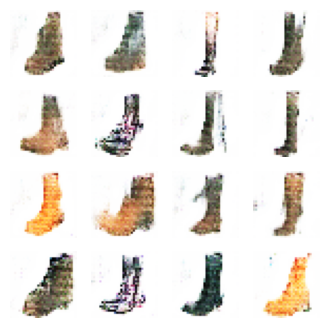

In [30]:
train(train_dataset, EPOCHS)